In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/mnt/disk3/projects/thaind/Medical-Image-Synthesis/guided-diffusion')

from guided_diffusion.image_datasets import PETDataset, CTDataset
from skimage.metrics import structural_similarity as ssim
import torch
from torch.utils.data import DataLoader
from torchvision.models import inception_v3
from scipy import linalg

In [44]:
# Chuẩn bị mô hình Inception
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [9]:
test_path = '/mnt/disk3/projects/thaind/Medical-Image-Synthesis/guided-diffusion/ckpt/openai-2023-06-27-22-49-02-832667/samples_20x128x128x3.npz'
data = np.load(test_path)

imgs = data['arr_0']
#labels = data['arr_1']
print(imgs.shape)
#print(labels)

(40, 128, 128, 3)


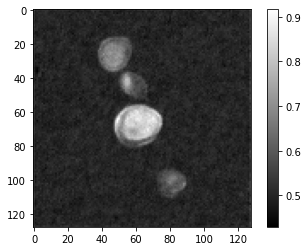

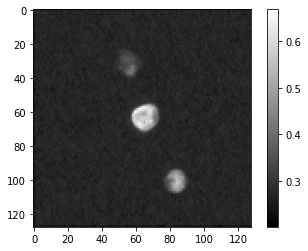

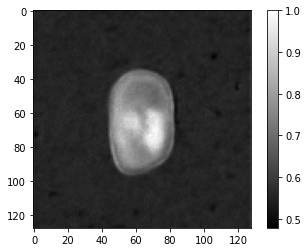

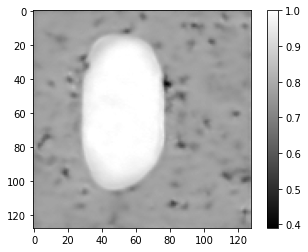

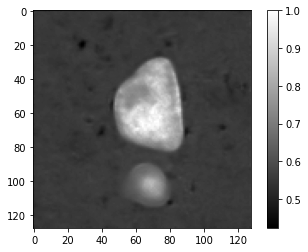

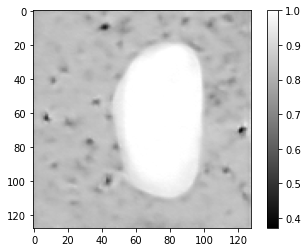

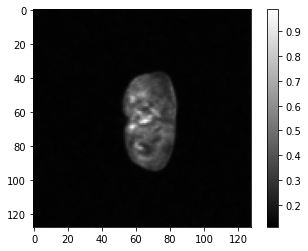

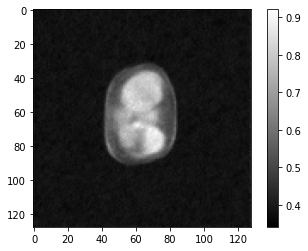

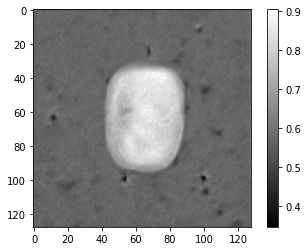

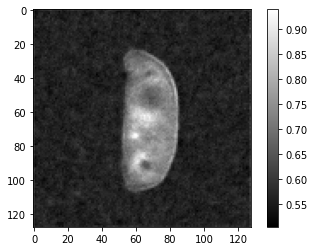

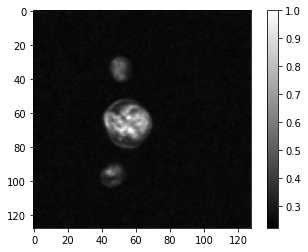

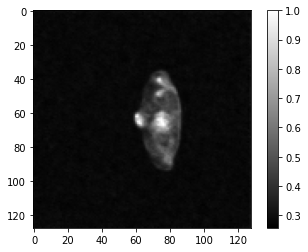

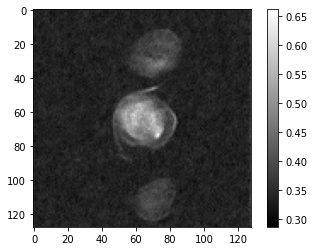

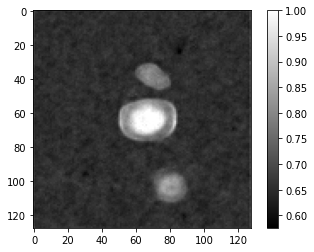

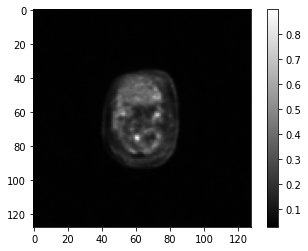

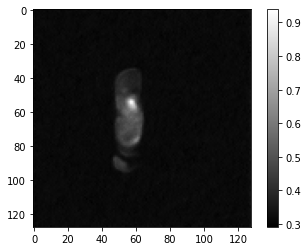

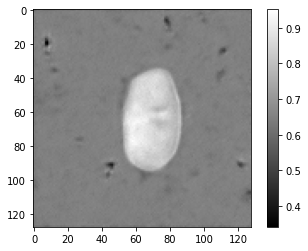

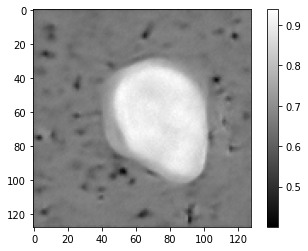

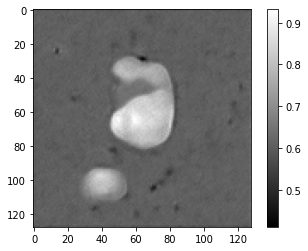

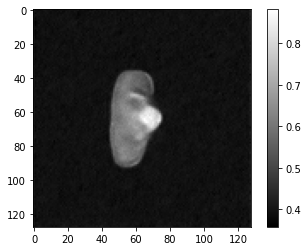

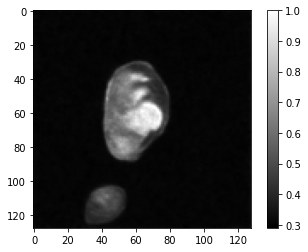

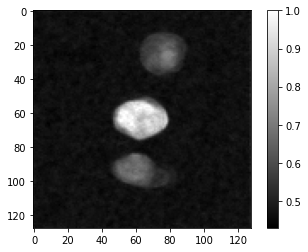

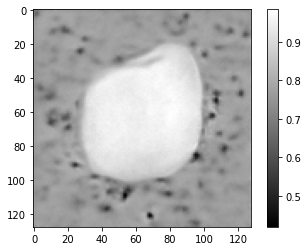

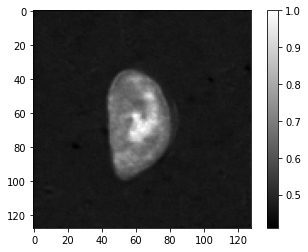

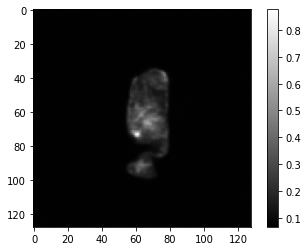

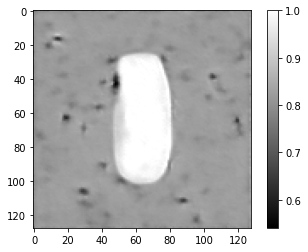

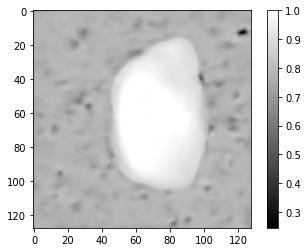

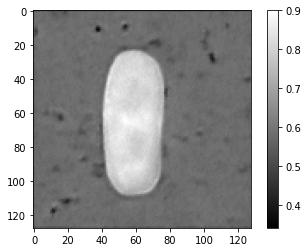

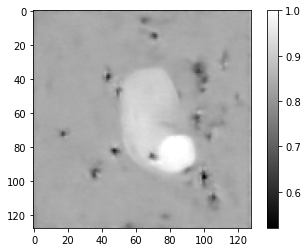

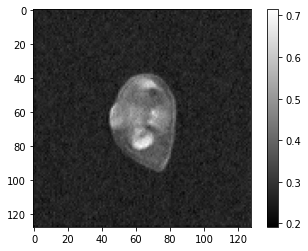

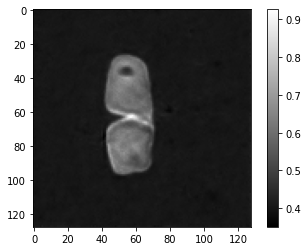

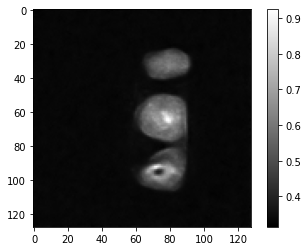

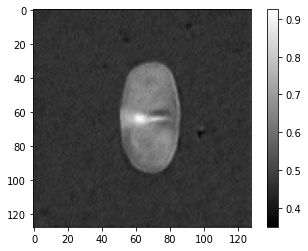

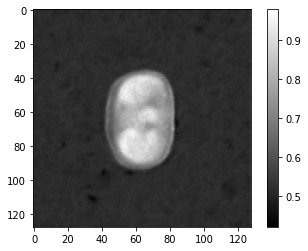

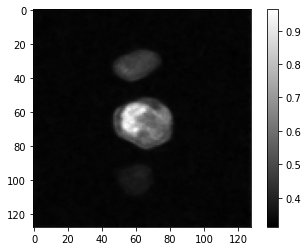

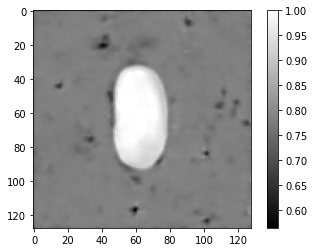

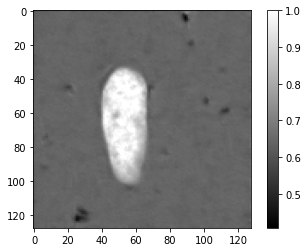

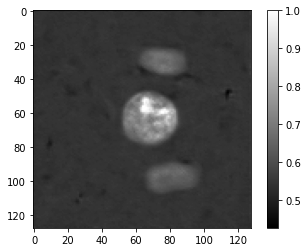

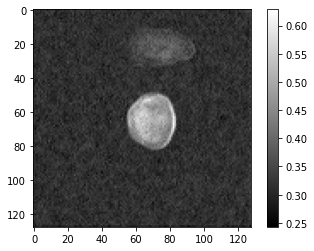

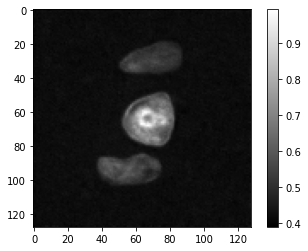

In [10]:
for img in imgs:
    img = img[:, :, 0]
    plt.imshow(img, cmap='gray')
    plt.colorbar()
    plt.show()

In [47]:
num_test_samples = 29

pred_dataset = []

for id in range(num_test_samples):
    pred_path = '/home/aiotlab/projects/thaind/Medical-Image-Synthesis/EGSDE/runs/pet2ct/{}/pred_10x128x128x3.npz'.format(id)
    pred_data = np.load(pred_path)

    pred_imgs = pred_data['arr_0']

    pred_dataset.append(pred_imgs)

pred_dataset = np.concatenate(pred_dataset)
print(pred_dataset.shape)

(290, 128, 128, 3)


(290, 128, 128, 3)
(290, 128, 128, 3)


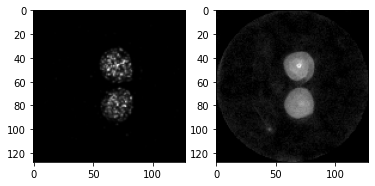

SSIM: -0.021979114040732384
PSNR: 6.065495860702682


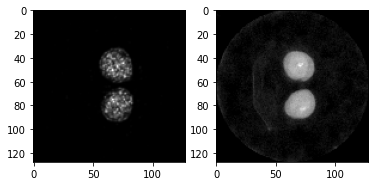

SSIM: -0.026492372155189514
PSNR: 6.126323156401799


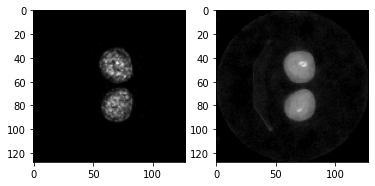

SSIM: -0.03522971272468567
PSNR: 6.119662643388223


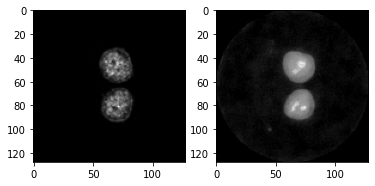

SSIM: -0.03958200290799141
PSNR: 6.103319391743779


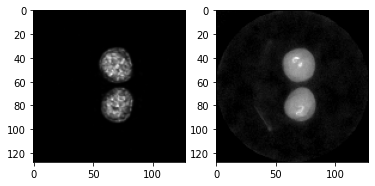

SSIM: -0.04011700674891472
PSNR: 6.12407628258874


In [48]:
pet_dir = '../../datasets/multimodal_slices/pet'
ct_dir = '../../datasets/multimodal_slices/ct'
test_split_dir = '../../datasets/test_split.txt'

test_flist = []

with open(test_split_dir, 'r') as f:
    test_flist = f.read().split('\n')

test_flist = test_flist[:-1]

pet_data = PETDataset(pet_dir, test_flist, False)
ct_data = CTDataset(ct_dir, test_flist, False)

pet_dataset = []
ct_dataset = []

for i in range(pred_dataset.shape[0]):
    img = np.transpose(pet_data[i][0], (1, 2, 0))
    pet_dataset.append(img[np.newaxis, :])
    img = np.transpose(ct_data[i][0], (1, 2, 0))
    ct_dataset.append(img[np.newaxis, :])

pet_dataset = np.concatenate(pet_dataset)
ct_dataset = np.concatenate(ct_dataset)

print(pet_dataset.shape)
print(ct_dataset.shape)

display_samples = 5

for i in range(display_samples):
    gt_img = pet_dataset[i]
    pred_img = pred_dataset[i]

    ssim_score = ssim(gt_img,
                      pred_img, channel_axis=-1,
                      data_range=1)
    
    mse = np.sum((pred_img - gt_img) ** 2) / gt_img.size
    data_range = gt_img.max() - gt_img.min()
    psnr_score = 10 * np.log10((data_range ** 2) / mse)

    gt_img = gt_img[:, :, 0]
    pred_img = pred_img[:, :, 0]

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(gt_img, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(pred_img, cmap='gray')
    plt.show()

    print('SSIM: {}'.format(ssim_score))
    print('PSNR: {}'.format(psnr_score))

In [49]:
ssim_avg = 0
psnr_avg = 0

for i in range(pred_dataset.shape[0]):
    gt_img = pet_dataset[i]
    pred_img = pred_dataset[i]
    
    ssim_score = ssim(gt_img,
                      pred_img, channel_axis=-1,
                      data_range=1)
    
    mse = np.sum((pred_img - gt_img) ** 2) / gt_img.size
    data_range = gt_img.max() - gt_img.min()
    psnr_score = 10 * np.log10((data_range ** 2) / mse)

    ssim_avg += ssim_score
    psnr_avg += psnr_score

ssim_avg /= pred_dataset.shape[0]
psnr_avg /= pred_dataset.shape[0]

print('SSIM: {}'.format(ssim_avg))
print('PSNR: {}'.format(psnr_avg))

SSIM: -0.030907844193279743
PSNR: 6.0557317892826195


In [50]:
# Trích xuất đặc trưng từ tập dữ liệu thực tế
real_features = []
with torch.no_grad():
    for real_image in ct_dataset:
        real_image = torch.tensor(real_image, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2)
        features = inception_model(real_image)[0].view(real_image.shape[0], -1)
        real_features.append(features)
real_features = torch.cat(real_features, dim=0)
real_features = real_features.numpy()

In [51]:
# Trích xuất đặc trưng từ tập dữ liệu tạo ra bởi mô hình
fake_features = []
with torch.no_grad():
    for fake_image in pred_dataset:
        fake_image = torch.tensor(fake_image, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2)
        features = inception_model(fake_image)[0].view(fake_image.shape[0], -1)
        fake_features.append(features)
fake_features = torch.cat(fake_features, dim=0)
fake_features = fake_features.numpy()

In [52]:
# Hàm tính FID
def calculate_fid(real_features, fake_features):
    # Tính toán vector trung bình và ma trận hiệp phương sai
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)
    
    # Tính toán FID
    diff = mu_fake - mu_real

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma_fake.dot(sigma_real), disp=False)
    if not np.isfinite(covmean).all():
        eps=1e-6
        offset = np.eye(sigma_fake.shape[0]) * eps
        covmean = linalg.sqrtm((sigma_fake + offset).dot(sigma_real + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        print("hihi")
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    print(diff.dot(diff))
    tr_covmean = np.trace(covmean)
    return (diff.dot(diff) + np.trace(sigma_fake)
            + np.trace(sigma_real) - 2 * tr_covmean)

In [53]:
# Tính toán FID
fid_score = calculate_fid(real_features, fake_features)
print(f"FID score: {fid_score}")

hihi
7871.262
FID score: 12349.968750170661
